Pruebas Opi Analytics

## Sección A2.Datos abiertos CDMX

### EDA


In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import contextily
import geopandas as gpd
from shapely.geometry import Point,Polygon

pd.set_option('display.max_rows', 10000000000)

In [2]:
from pyspark.sql import SparkSession

spark=SparkSession.builder.getOrCreate()
path="/home/ivan/Descargas/carpetas-de-investigacion-pgj-cdmx.csv"
base=spark.read.csv(path,header=True)

¿Cuántos delitos registrados hay en la tabla? ¿Qué rango de tiempo consideran los
datos?

In [2]:
print('La base de datos contiene {valor} registros'.format(valor=base.count()))

La base de datos contiene 808871 registros


In [33]:
aos=base.select('año_hechos').toPandas()
lista_aos=aos['año_hechos'].unique()
lista_aos=list(filter(lambda x:x!='NA',lista_aos))
print('El rango de los datos es de {mini} a {maxi}'.format(mini=min((lista_aos)),maxi=max((lista_aos))))

El rango de los datos es de 1906 a 2019


¿Cómo se distribuye el número de delitos en la CDMX? ¿Cuáles son los 5 delitos más
frecuentes?

* Los delitos más frecuentes para los años 1906 y 2019  son : violencia familiar, robo de objetos y negocios, fraude y denuncia de hechos.

In [46]:
for i in base.columns:
    print(base.select(i).distinct().show())

+----------+
|año_hechos|
+----------+
|      1957|
|      1987|
|      1956|
|      2016|
|      2012|
|      1958|
|      1915|
|      1972|
|      1988|
|      2019|
|      2017|
|      1977|
|      2014|
|      1971|
|      1984|
|      2013|
|      1982|
|      2005|
|        NA|
|      2000|
+----------+
only showing top 20 rows

None
+----------+
|mes_hechos|
+----------+
|    Agosto|
|     Enero|
| Diciembre|
|        NA|
| Noviembre|
|     Marzo|
|Septiembre|
|   Febrero|
|      Mayo|
|     Julio|
|     Junio|
|   Octubre|
|     Abril|
+----------+

None
+-------------------+
|       fecha_hechos|
+-------------------+
|2016-03-20 12:00:00|
|2018-01-23 16:03:00|
|2016-03-27 17:00:00|
|2018-01-21 20:38:00|
|2016-01-15 13:48:00|
|2017-12-31 08:00:00|
|2018-01-11 11:00:00|
|2019-06-29 19:25:00|
|2019-06-28 16:00:00|
|2019-05-20 22:00:00|
|2012-11-13 16:30:00|
|2018-06-07 19:50:00|
|2017-05-08 00:00:00|
|2017-10-28 10:50:00|
|2019-03-21 13:30:00|
|2017-05-24 19:00:00|
|2016-01-08 

In [3]:
alcaldias=['CUAJIMALPA DE MORELOS','LA MAGDALENA CONTRERAS','TLAHUAC','XOCHIMILCO','IZTACALCO','AZCAPOTZALCO','TLALPAN','VENUSTIANO CARRANZA','ALVARO OBREGON','MIGUEL HIDALGO','COYOACAN', 'BENITO JUAREZ', 'BENITO JUAREZ', 'BENITO JUAREZ', 'IZTAPALAPA', 'CUAUHTEMOC']

In [5]:
base.filter((base.alcaldia_hechos.isin(alcaldias))).count()

714951

In [4]:
cdmx=base.filter((base.alcaldia_hechos.isin(alcaldias)))

In [36]:
delitos_cdmx=cdmx.groupBy('delito').count().orderBy('count',ascending=False).toPandas()

In [41]:
delitos_cdmx.iloc[0:5,:]

,delito,count
0,VIOLENCIA FAMILIAR,60433
1,ROBO DE OBJETOS,47403
2,ROBO A NEGOCIO SIN VIOLENCIA,45713
3,FRAUDE,41588
4,DENUNCIA DE HECHOS,39296


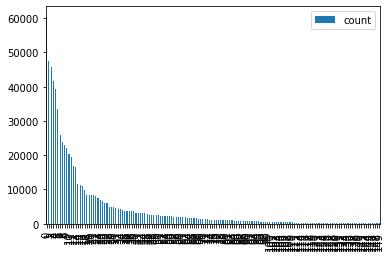

In [49]:
delitos_cdmx[delitos_cdmx['count']>100].plot.bar()

Identifica los delitos que van a la alza y a la baja en la CDMX en el último año (ten
cuidado con los delitos con pocas ocurrencias).

* Al verificar la tasa de variación en el número de delitos, llama la atención que los delitos relacionados con DDH registraran incrementos acentuados, en tanto que los robos a transeuntes registraron una contracción entre el periodo 2018 y 2019.

In [50]:
cdmx_delitos2019=cdmx.filter(cdmx.año_hechos=='2019').groupBy('delito').count().toPandas()
cdmx_delitos2018=cdmx.filter(cdmx.año_hechos=='2018').groupBy('delito').count().toPandas()

cdmx_delitos_comparativos=cdmx_delitos2018.merge(cdmx_delitos2019, left_on='delito', right_on='delito')
cdmx_delitos_comparativos['tasa_var']=(pd.to_numeric(cdmx_delitos_comparativos['count_y'])/pd.to_numeric(cdmx_delitos_comparativos['count_x']) -1) *100

In [51]:
cdmx_delitos_comparativos.sort_values('tasa_var',ascending=False)

,delito,count_x,count_y,tasa_var
214,DDH RELACIONADAS,1,46,4500.000000
194,PERSONAS EXTRAVIADAS,4,132,3200.000000
71,DDH OFICIO COLABORACION,1,11,1000.000000
131,PLAGIO O SECUESTRO,4,29,625.000000
188,DDH OTRAS MATERIAS,6,38,533.333333
3,DDH SIN DATOS,2,11,450.000000
22,ROBO A PASAJERO EN TREN SUBURBANO SIN VIOLENCIA,1,4,300.000000
27,GESTIÓN AMBIENTAL,1,4,300.000000
165,ROBO A TRANSEUNTE SALIENDO DEL CAJERO CON VIOL...,19,71,273.684211
212,COBRANZA ILEGITIMA,22,74,236.363636


¿Cuál es la alcaldía que más delitos tiene y cuál es la que menos?.¿Por qué crees que sea
esto?

In [5]:
cdmx.groupBy('alcaldia_hechos').count().orderBy('count').show()

+--------------------+------+
|     alcaldia_hechos| count|
+--------------------+------+
|CUAJIMALPA DE MOR...| 11393|
|LA MAGDALENA CONT...| 12064|
|             TLAHUAC| 18197|
|          XOCHIMILCO| 24639|
|           IZTACALCO| 34407|
|        AZCAPOTZALCO| 39435|
|             TLALPAN| 46179|
| VENUSTIANO CARRANZA| 46224|
|      ALVARO OBREGON| 52568|
|      MIGUEL HIDALGO| 53688|
|            COYOACAN| 54235|
|       BENITO JUAREZ| 70599|
|          IZTAPALAPA|119926|
|          CUAUHTEMOC|131397|
+--------------------+------+



Dentro de cada alcaldía, cuáles son las tres colonias con más delitos

In [7]:
cdmx_slice=cdmx.select('año_hechos','mes_hechos','delito','colonia_hechos','alcaldia_hechos','latitud','longitud','Geopoint').toPandas()

In [8]:
cdmx_slice.head()

,año_hechos,mes_hechos,delito,colonia_hechos,alcaldia_hechos,latitud,longitud,Geopoint
0,2017,Noviembre,ROBO A TRANSEUNTE EN VIA PUBLICA CON VIOLENCIA,GABRIEL RAMOS MILLÁN SECCIÓN TLACOTAL,IZTACALCO,19.3953976727268,-99.1060723828598,"19.3953976727,-99.1060723829"
1,2015,Diciembre,FRAUDE,CONSEJO AGRARISTA MEXICANO,IZTAPALAPA,19.3224579998342,-99.0558869999999,"19.3224579998,-99.055887"
2,2018,Mayo,ROBO A REPARTIDOR CON VIOLENCIA,DESARROLLO URBANO QUETZALCOATL,IZTAPALAPA,19.3191405147091,-99.0427862525713,"19.3191405147,-99.0427862526"
3,2018,Mayo,ROBO A TRANSEUNTE DE CELULAR CON VIOLENCIA,INFONAVIT IZTACALCO,IZTACALCO,19.3865939283956,-99.1115626681669,"19.3865939284,-99.1115626682"
4,2018,Mayo,ROBO A TRANSEUNTE DE CELULAR CON VIOLENCIA,TLACOQUEMECATL,BENITO JUAREZ,19.3795809108208,-99.1771001785472,"19.3795809108,-99.1771001785"


In [12]:
cdmx2019=cdmx_slice[cdmx_slice['año_hechos']=='2019']

In [14]:
cdmx2019.head()

,año_hechos,mes_hechos,delito,colonia_hechos,alcaldia_hechos,latitud,longitud,Geopoint
1859,2019,Junio,ROBO A NEGOCIO CON VIOLENCIA,CENTRAL DE ABASTO,IZTAPALAPA,19.3686642496323,-99.0871816719506,"19.3686642496,-99.087181672"
1861,2019,Junio,ROBO A NEGOCIO SIN VIOLENCIA,PEÑA POBRE,TLALPAN,19.2954610993569,-99.1819126001972,"19.2954610994,-99.1819126002"
1867,2019,Junio,VIOLENCIA FAMILIAR,PEDREGAL DE SANTA URSULA,COYOACAN,19.3110251953719,-99.1560859995587,"19.3110251954,-99.1560859996"
1874,2019,Junio,FRAUDE,JARDINES DE SAN LORENZO TEZONCO,IZTAPALAPA,19.2962296034935,-99.0725272000507,"19.2962296035,-99.0725272001"
1876,2019,Junio,ABUSO DE AUTORIDAD,EL TRIUNFO,IZTAPALAPA,19.3796993026197,-99.1212315999232,"19.3796993026,-99.1212315999"


In [15]:
fig, ax = plt.subplots()
ax.plot(cdmx2019['longitud'], cdmx2019['latitud'], 'o', markersize=1)
contextily.add_basemap(ax)
plt.show()

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/ivan/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-15-c11b9d73ad60>", line 3, in <module>
    contextily.add_basemap(ax)
  File "/home/ivan/anaconda3/lib/python3.7/site-packages/contextily/plotting.py", line 219, in add_basemap
    add_attribution(ax, attribution, font_size=attribution_size)
  File "/home/ivan/anaconda3/lib/python3.7/site-packages/contextily/plotting.py", line 252, in add_attribution
    draw()
  File "/home/ivan/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py", line 723, in draw
    get_current_fig_manager().canvas.draw_idle()
  File "/home/ivan/anaconda3/lib/python3.7/site-packages/matplotlib/backend_bases.py", line 1916, in draw_idle
    self.draw(*args, **kwargs)
  File "/home/ivan/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py", line 388, in draw
    self

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7fa4ac9dcb90> (for post_execute):


KeyboardInterrupt: 

In [5]:
def delitos(bdd):
    df=bdd[['delito']]
    df['vol']=1
    output=pd.DataFrame(df.groupby(['delito'])['vol'].sum())
    #aos=df['ao'].unique()
    #aos_clean=list(filter(lambda x:x!='NA',aos))
    #print('El rango de los delitos reportados es de: {rango} años, desde {mini} hasta {maxi}'.format(rango=str(int(max(aos_clean))-int(min(aos_clean))),mini=str(int(min(aos_clean))),maxi=str(int(max(aos_clean)))))
    
    return output,aos

In [ ]:
delitos(bdd)[0]

## Sección B


La base de datos continene inconsistencias en la identificación de los artículos que se reportan. Los valores corresopndientes a categoría y estado contienen etiquetas que no corresoponden al conjunto que se indica. 

In [4]:
import pyspark
from pyspark.sql import SQLContext
sc = pyspark.SparkContext()
sql = SQLContext(sc)

df = (sql.read
         .format("com.databricks.spark.csv")
         .option("header", "true")
         .load("/home/ivan/Descargas/all_data.csv"))

In [2]:
df.columns

['producto',
 'presentacion',
 'marca',
 'categoria',
 'catalogo',
 'precio',
 'fechaRegistro',
 'cadenaComercial',
 'giro',
 'nombreComercial',
 'direccion',
 'estado',
 'municipio',
 'latitud',
 'longitud']

In [12]:
df.head(10)

[Row(producto='CUADERNO FORMA ITALIANA', presentacion='96 HOJAS PASTA DURA. CUADRICULA CHICA', marca='ESTRELLA', categoria='MATERIAL ESCOLAR', catalogo='UTILES ESCOLARES', precio='25.9', fechaRegistro='2011-05-18 00:00:00.000', cadenaComercial='ABASTECEDORA LUMEN', giro='PAPELERIAS', nombreComercial='ABASTECEDORA LUMEN SUCURSAL VILLA COAPA', direccion='CANNES No. 6 ESQ. CANAL DE MIRAMONTES', estado='DISTRITO FEDERAL', municipio='TLALPAN                                 ', latitud='19.29699', longitud='-99.125417'),
 Row(producto='CRAYONES', presentacion='CAJA 12 CERAS. JUMBO. C.B. 201423', marca='CRAYOLA', categoria='MATERIAL ESCOLAR', catalogo='UTILES ESCOLARES', precio='27.5', fechaRegistro='2011-05-18 00:00:00.000', cadenaComercial='ABASTECEDORA LUMEN', giro='PAPELERIAS', nombreComercial='ABASTECEDORA LUMEN SUCURSAL VILLA COAPA', direccion='CANNES No. 6 ESQ. CANAL DE MIRAMONTES', estado='DISTRITO FEDERAL', municipio='TLALPAN                                 ', latitud='19.29699', long

In [4]:
df.show()

+--------------------+--------------------+--------------------+--------------------+-----------------+------+--------------------+------------------+--------------------+--------------------+--------------------+----------------+--------------------+--------+----------+
|            producto|        presentacion|               marca|           categoria|         catalogo|precio|       fechaRegistro|   cadenaComercial|                giro|     nombreComercial|           direccion|          estado|           municipio| latitud|  longitud|
+--------------------+--------------------+--------------------+--------------------+-----------------+------+--------------------+------------------+--------------------+--------------------+--------------------+----------------+--------------------+--------+----------+
|CUADERNO FORMA IT...|96 HOJAS PASTA DU...|            ESTRELLA|    MATERIAL ESCOLAR| UTILES ESCOLARES|  25.9|2011-05-18 00:00:...|ABASTECEDORA LUMEN|          PAPELERIAS|ABASTECEDORA 

In [31]:
df.select('cadenaComercial').show()

+------------------+
|   cadenaComercial|
+------------------+
|ABASTECEDORA LUMEN|
|ABASTECEDORA LUMEN|
|ABASTECEDORA LUMEN|
|ABASTECEDORA LUMEN|
|ABASTECEDORA LUMEN|
|ABASTECEDORA LUMEN|
|ABASTECEDORA LUMEN|
|ABASTECEDORA LUMEN|
|ABASTECEDORA LUMEN|
|COMERCIAL MEXICANA|
|COMERCIAL MEXICANA|
|COMERCIAL MEXICANA|
|COMERCIAL MEXICANA|
|COMERCIAL MEXICANA|
|COMERCIAL MEXICANA|
|COMERCIAL MEXICANA|
|COMERCIAL MEXICANA|
|COMERCIAL MEXICANA|
|COMERCIAL MEXICANA|
|COMERCIAL MEXICANA|
+------------------+
only showing top 20 rows



In [ ]:
df.filter()

### Procesamiento de datos

In [5]:
df.registerTempTable("connections")
query1= sql.sql("""SELECT estado, COUNT(*) as f FROM connections GROUP BY estado""")

In [19]:
query1.show()

+--------------------+--------+
|              estado|       f|
+--------------------+--------+
|        QUINTANA ROO| 2076525|
|          NUEVO LEÓN| 3171091|
|             SINALOA| 1720736|
|             TABASCO| 1842633|
|     BAJA CALIFORNIA| 1200999|
|            TLAXCALA| 2081024|
|COAHUILA DE ZARAGOZA| 1498109|
|                null|   15054|
|       ESQ. SUR 125"|     132|
|             CHIAPAS|  527160|
| COL. EDUARDO GUERRA|   14364|
|VERACRUZ DE IGNAC...|  690420|
|              SONORA| 1698620|
|             YUCATÁN| 2300994|
| MICHOACÁN DE OCAMPO| 2093037|
|             DURANGO|  563269|
|            GUERRERO|  485470|
|             NAYARIT|  419547|
|           CHIHUAHUA|  919673|
|    DISTRITO FEDERAL|11283970|
+--------------------+--------+
only showing top 20 rows



In [20]:
obs=query1.toPandas()

In [27]:
obs.sum() # observaciones

f    62530715
dtype: int64

In [32]:
query2=sql.sql("""SELECT categoria,COUNT(*) as num FROM connections GROUP BY categoria""")
query3=sql.sql("""SELECT DISTINCT cadenaComercial FROM connections """)

In [33]:
query3.show()

+--------------------+
|     cadenaComercial|
+--------------------+
|JULIO CEPEDA JUGU...|
|           WOOLWORTH|
| MARISCOS LA SEPTIMA|
|PAPELERIA EL TINTERO|
|LIBRERIA DE SANCH...|
|PAPELERIA Y LIBRE...|
|     PLAZA DEL LIBRO|
|MERCADO ALONSO FE...|
|     MERCADO LA CRUZ|
|     ZAPATERIA PAKAR|
|              SIGUBA|
|           MEGA TOYS|
| MARISCOS VILLA AZUL|
|    BODEGAS VICTORIA|
|     MINISUPER INALA|
|              S MART|
|    LIBRERIA ATHENAS|
|        FARMACIAS M+|
| MUEBLERIA CREDILAND|
|   LOYEP (UNIFORMES)|
+--------------------+
only showing top 20 rows



In [34]:
cadenas=query3.toPandas()

In [36]:
cadenas

['cadenaComercial']

In [39]:
query4=sql.sql("""SELECT estado, SUM(latitud)/COUNT(latitud) AS cen_lat, SUM(longitud)/COUNT(longitud) AS cen_lon, COUNT(*) AS obs FROM connections GROUP BY estado """)

In [40]:
centroides=query4.toPandas()

In [45]:
centroides_filtro=centroides.loc[pd.notnull(centroides.cen_lat)]

In [48]:
centroides_filtro

,estado,cen_lat,cen_lon,obs
0,QUINTANA ROO,20.142973,-84.550827,2076525
1,NUEVO LEÓN,25.426007,-99.241443,3171091
2,SINALOA,24.562288,-105.423606,1720736
3,TABASCO,17.858576,-92.292192,1842633
4,BAJA CALIFORNIA,32.330195,-115.549282,1200999
5,TLAXCALA,18.954363,-96.300570,2081024
6,COAHUILA DE ZARAGOZA,25.857307,-100.056103,1498109
7,None,18.591340,-95.029778,15054
9,CHIAPAS,15.940357,-92.008948,527160
11,VERACRUZ DE IGNACIO DE LA LLAVE,17.961237,-90.113320,690420


In [51]:
geometry=[Point(xy) for xy in zip(centroides_filtro['cen_lat'],centroides_filtro['cen_lon'])]

In [119]:
crs={'init': 'epsg:4326'}
cen_geom=gpd.GeoDataFrame(centroides_filtro,geometry=geometry,crs=crs)
cen_geom

/home/ivan/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


,estado,cen_lat,cen_lon,obs,geometry
0,QUINTANA ROO,20.142973,-84.550827,2076525,POINT (20.143 -84.551)
1,NUEVO LEÓN,25.426007,-99.241443,3171091,POINT (25.426 -99.241)
2,SINALOA,24.562288,-105.423606,1720736,POINT (24.562 -105.424)
3,TABASCO,17.858576,-92.292192,1842633,POINT (17.859 -92.292)
4,BAJA CALIFORNIA,32.330195,-115.549282,1200999,POINT (32.330 -115.549)
5,TLAXCALA,18.954363,-96.300570,2081024,POINT (18.954 -96.301)
6,COAHUILA DE ZARAGOZA,25.857307,-100.056103,1498109,POINT (25.857 -100.056)
7,None,18.591340,-95.029778,15054,POINT (18.591 -95.030)
9,CHIAPAS,15.940357,-92.008948,527160,POINT (15.940 -92.009)
11,VERACRUZ DE IGNACIO DE LA LLAVE,17.961237,-90.113320,690420,POINT (17.961 -90.113)


### Visualización

In [21]:
def visualizacion(insumo):
    query4=sql.sql("""SELECT estado,municipio,SUM(latitud)/COUNT(latitud) AS cen_lat, SUM(longitud)/COUNT(longitud) AS cen_lon, COUNT(*) AS obs  
    FROM connections 
    WHERE estado='{entidad}'
    GROUP BY estado, municipio""".format(entidad=str(insumo)))
    df=query4.toPandas()
    geometry=[Point(xy) for xy in zip(df['cen_lat'],df['cen_lon'])]
    df=gpd.GeoDataFrame(df,geometry=geometry)
    #cen_geom
    return df

In [22]:
visualizacion('GUANAJUATO')

,estado,municipio,cen_lat,cen_lon,obs,geometry
0,GUANAJUATO,LEÓN,21.014085,-100.312678,729987,POINT (21.014 -100.313)
1,GUANAJUATO,LEON,20.920027,-100.158095,1908469,POINT (20.920 -100.158)


¿Cuántas categorías?

In [ ]:
base.groupBy('categoria').count().show()

¿Cuántos registros hay?

In [ ]:
print('La base de datos contiene {valor} registros'.format(valor=base.count()))

¿Cuántas cadenas comerciales están siendo monitoreadas?

In [ ]:
base.groupBy('cadenaComercial').count().show()

¿Cuáles son los productos más monitoreados en cada entidad?

In [ ]:
tabla_edoprod=base.groupBy('estado','producto').count().toPandas()

In [ ]:
tabla_edoprod.sort_values(['estado','producto'],ascending=False)

¿Cómo podrías determinar la calidad de los datos? ¿Detectaste algún tipo de
inconsistencia o error en la fuente?

Existe una categoría con la etiqueta null, esto podría implicar que las canastas de consumo no esten propiamente actualizadas